In [5]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
seed = 45
import lifelines
from lifelines import KaplanMeierFitter

import xgboost as xgb
from xgboost import XGBClassifier
from pdpbox import pdp, get_dataset, info_plots
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score ,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
data = pd.read_excel("cancer-hard.xlsx")
print(data.shape)

(61, 107)


In [7]:
#Label encoding

number = LabelEncoder()
for i in data.columns:
    if (data[i].dtype == 'object' or 'category' in str(data[i].dtype)):
        data[i] = number.fit_transform(data[i].astype('str'))

In [8]:
X = data.drop(['PROGEVAL', 'REVAL', 'IDIM', 'DDEBUT', 'DDNEWS'],axis=1)
y = data['PROGEVAL']

In [9]:
X.shape, y.shape

((61, 102), (61,))

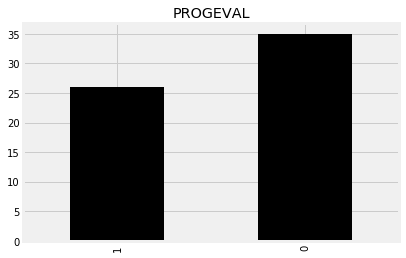

In [10]:
data['PROGEVAL'].value_counts().sort_values().tail(10).plot(kind = "bar", title = "PROGEVAL",color = "black");

In [11]:
data['PROGEVAL'].value_counts()  

0    35
1    26
Name: PROGEVAL, dtype: int64

### Kaplan Meier Survival Curve

In [12]:
kmf = KaplanMeierFitter()

In [13]:
T = data['SurvivalDays']
S = data['DECES'] 
groups = data['PROGEVAL']
g0 = (groups == 0)
g1 = (groups == 1)

In [14]:
kmf.fit(T[g0], S[g0], label = "No Progress of Cancer after PROGEVAL")

<lifelines.KaplanMeierFitter:"No Progress of Cancer after PROGEVAL", fitted with 35 total observations, 20 right-censored observations>

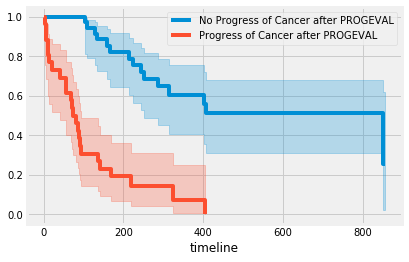

In [15]:
a = kmf.plot()
kmf.fit(T[g1], S[g1], label = "Progress of Cancer after PROGEVAL")
kmf.plot(ax=a)

In [16]:
kmf1 = KaplanMeierFitter()

In [17]:
T1 = data['SurvivalDays']
S1 = data['PROGEVAL'] 
groups1 = data['DECES']
g0 = (groups1 == 0)
g1 = (groups1 == 1)

In [18]:
kmf1.fit(T1[g0], S1[g0], label = "Status is Alive")

<lifelines.KaplanMeierFitter:"Status is Alive", fitted with 22 total observations, 20 right-censored observations>

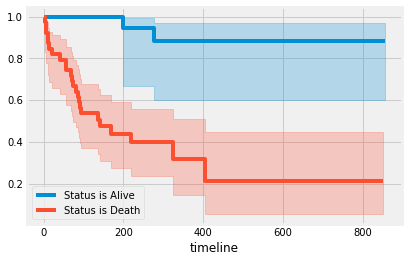

In [19]:
a = kmf1.plot()
kmf1.fit(T1[g1], S1[g1], label = "Status is Death")
kmf1.plot(ax=a)

###  Cross Validation with different models

In [8]:
# get a list of models to evaluate

def get_models():
    models = dict()
    
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])

    # ADA
    rfe = RFE(estimator=AdaBoostClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['ada'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # DT
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['dt'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    # gbm
    rfe = RFE(estimator=XGBClassifier(), n_features_to_select=10)
    model = DecisionTreeClassifier()
    models['xgb'] = Pipeline(steps=[('s',rfe),('m',model)])
    
    return models
 

In [9]:
from sklearn.linear_model import Perceptron
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from numpy import mean
from numpy import std

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.578 (0.198)
>ada 0.768 (0.182)
>dt 0.700 (0.197)
>rf 0.692 (0.173)
>xgb 0.669 (0.178)


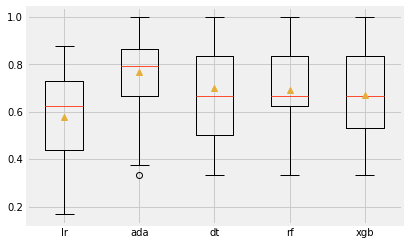

In [10]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### ROC with Cross Validation

In [11]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier()
cv = StratifiedKFold(n_splits=10,shuffle=False)

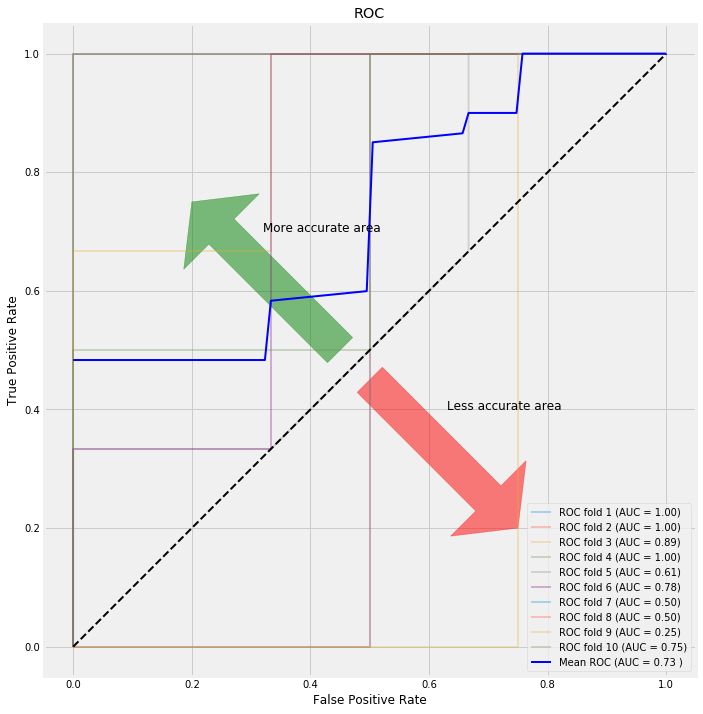

In [12]:
import matplotlib.patches as patches
from scipy import interp

# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5))
ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X,y):
    prediction = clf.fit(X.iloc[train],y.iloc[train]).predict_proba(X.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()    

### Automatically Select the Number of Features

In [13]:
from sklearn.feature_selection import RFECV

# create pipeline
rfe = RFECV(estimator=RandomForestClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.681 (0.200)


In [14]:
# define RFE
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=1)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 41.000
Column: 1, Selected False, Rank: 46.000
Column: 2, Selected False, Rank: 20.000
Column: 3, Selected False, Rank: 37.000
Column: 4, Selected False, Rank: 2.000
Column: 5, Selected False, Rank: 4.000
Column: 6, Selected False, Rank: 5.000
Column: 7, Selected False, Rank: 7.000
Column: 8, Selected False, Rank: 33.000
Column: 9, Selected False, Rank: 10.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 66.000
Column: 12, Selected False, Rank: 16.000
Column: 13, Selected False, Rank: 45.000
Column: 14, Selected False, Rank: 59.000
Column: 15, Selected False, Rank: 70.000
Column: 16, Selected False, Rank: 87.000
Column: 17, Selected False, Rank: 9.000
Column: 18, Selected False, Rank: 17.000
Column: 19, Selected False, Rank: 26.000
Column: 20, Selected False, Rank: 43.000
Column: 21, Selected False, Rank: 30.000
Column: 22, Selected False, Rank: 79.000
Column: 23, Selected False, Rank: 49.000
Column: 24, Selected False, Rank:

### Recursive Feature Elimination with Cross-Validation

In [15]:
rfecv = RFECV(RandomForestClassifier(), step=10, scoring='roc_auc', cv=10, verbose=1)
rfecv.fit(X, y)

Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30

RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc', step=10,
      verbose=1)

In [ ]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

In [ ]:
print(X.columns[rfecv.ranking_ == 1].values) #Selected Features

In [ ]:
#print(X_train.columns[rfecv.ranking_ != 1].values) #Not selected Features

In [ ]:
#Optimal number of features: 10

train = X[['original_shape_Elongation', 
           'original_shape_MajorAxisLength',
           'original_shape_Maximum2DDiameterColumn',
           'original_shape_Maximum2DDiameterRow',
           'original_shape_Maximum2DDiameterSlice',
           'original_shape_Maximum3DDiameter',
           'original_shape_MinorAxisLength',
           'original_shape_Sphericity',
           'original_firstorder_Entropy',
           'original_firstorder_RobustMeanAbsoluteDeviation']]        

In [ ]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)
plt.show()

### BoxPlot with 10 splits and 30 repeats

In [29]:
from scipy.stats import sem
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    model = RandomForestClassifier()
    scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    return scores

repeats = range(1,31)
results = list()
for r in repeats:
    scores = evaluate_model(X, y, r)
    print('>%d mean=%.4f se=%.3f' % (r, mean(scores), sem(scores)))
    
    results.append(scores)

>1 mean=0.6658 se=0.055
>2 mean=0.6737 se=0.043
>3 mean=0.6781 se=0.038
>4 mean=0.7044 se=0.034
>5 mean=0.6452 se=0.035
>6 mean=0.6693 se=0.029
>7 mean=0.6600 se=0.027
>8 mean=0.6778 se=0.026
>9 mean=0.6868 se=0.024
>10 mean=0.6707 se=0.023
>11 mean=0.6805 se=0.021
>12 mean=0.6688 se=0.019
>13 mean=0.6806 se=0.019
>14 mean=0.6804 se=0.018
>15 mean=0.6778 se=0.017
>16 mean=0.6929 se=0.016
>17 mean=0.6984 se=0.016
>18 mean=0.6920 se=0.016
>19 mean=0.6786 se=0.015
>20 mean=0.6946 se=0.015
>21 mean=0.6898 se=0.014
>22 mean=0.6836 se=0.013
>23 mean=0.6914 se=0.014
>24 mean=0.6907 se=0.013
>25 mean=0.6829 se=0.013
>26 mean=0.6849 se=0.012
>27 mean=0.6830 se=0.012
>28 mean=0.6742 se=0.012
>29 mean=0.6920 se=0.011
>30 mean=0.6983 se=0.011


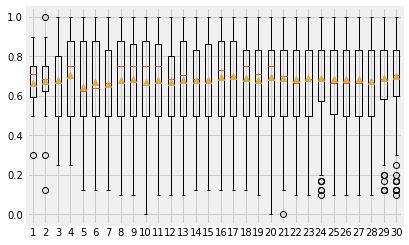

In [30]:
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.show()

### Confusion Matrix to check false positive and false negative patients

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [121]:
y_train.shape, y_test.shape

((42,), (19,))

In [122]:
classifier = RandomForestClassifier().fit(X_train,y_train) 
y_pred =classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.737


In [123]:
from sklearn.metrics import plot_confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test,y_pred, labels=[0, 1]).ravel()
(tn, fp, fn, tp)

(8, 1, 4, 6)

In [ ]:
#false positive is 1 and false negative is 4

In [124]:
print (y_test)

0     1
5     1
46    1
31    0
13    0
55    1
34    1
49    0
12    0
40    0
33    0
59    1
16    0
3     1
53    0
17    1
8     0
6     1
41    1
Name: PROGEVAL, dtype: int64


In [125]:
print (y_pred)

[1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0]


In [ ]:
"""

55    1  0  #Patient number 65 false negative
40    0  1  #Patient number 49 false positive
59    1  0  #Patient number 69 false negative
6     1  0  #Patient number 08 false negative
41    1  0  #Patient number 50 false negative

"""

### Recursive Feature Elimination with Cross-Validation

In [18]:
rfecv = RFECV(RandomForestClassifier(), step=10, scoring='roc_auc', cv=10, verbose=1)
rfecv.fit(X, y)

Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30 features.
Fitting estimator with 20 features.
Fitting estimator with 10 features.
Fitting estimator with 100 features.
Fitting estimator with 90 features.
Fitting estimator with 80 features.
Fitting estimator with 70 features.
Fitting estimator with 60 features.
Fitting estimator with 50 features.
Fitting estimator with 40 features.
Fitting estimator with 30

RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc', step=10,
      verbose=1)

In [19]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 10


In [20]:
print(X.columns[rfecv.ranking_ == 1].values) #Selected Features

['original_shape_LeastAxisLength' 'original_shape_Maximum2DDiameterColumn'
 'original_shape_Maximum2DDiameterRow'
 'original_shape_Maximum2DDiameterSlice'
 'original_shape_Maximum3DDiameter' 'original_shape_MinorAxisLength'
 'original_shape_Sphericity' 'original_firstorder_MeanAbsoluteDeviation'
 'original_glcm_SumEntropy'
 'original_gldm_LargeDependenceLowGrayLevelEmphasis']


In [135]:
#print(X_train.columns[rfecv.ranking_ != 1].values) #Not selected Features

In [21]:
#Optimal number of features: 10

train = X[['original_shape_LeastAxisLength',
           'original_shape_Maximum2DDiameterColumn',
           'original_shape_Maximum2DDiameterRow',
            'original_shape_Maximum2DDiameterSlice',
           'original_shape_Maximum3DDiameter',
           'original_shape_MinorAxisLength',
            'original_shape_Sphericity', 
           'original_firstorder_MeanAbsoluteDeviation',
            'original_glcm_SumEntropy',
            'original_gldm_LargeDependenceLowGrayLevelEmphasis']]        

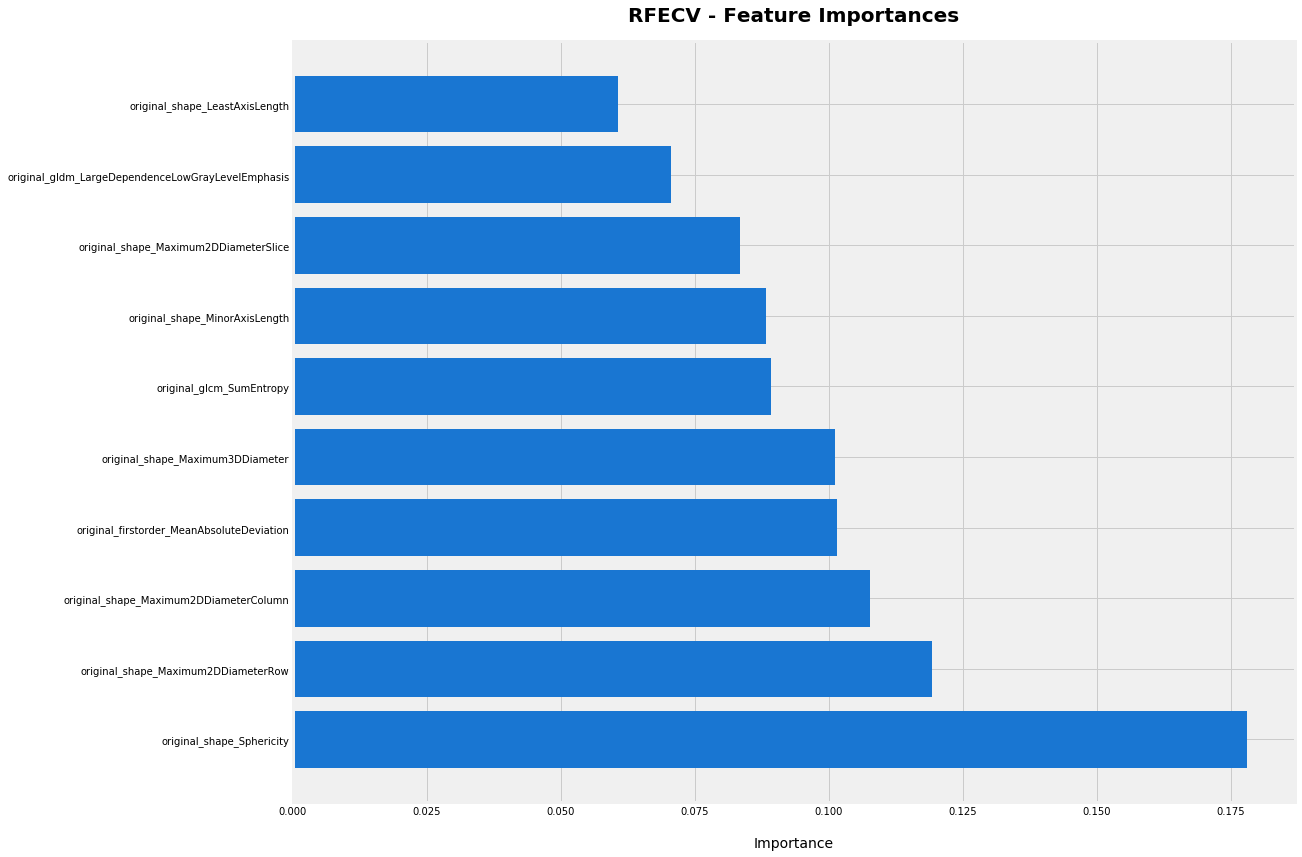

In [22]:
dset = pd.DataFrame()
dset['attr'] = train.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

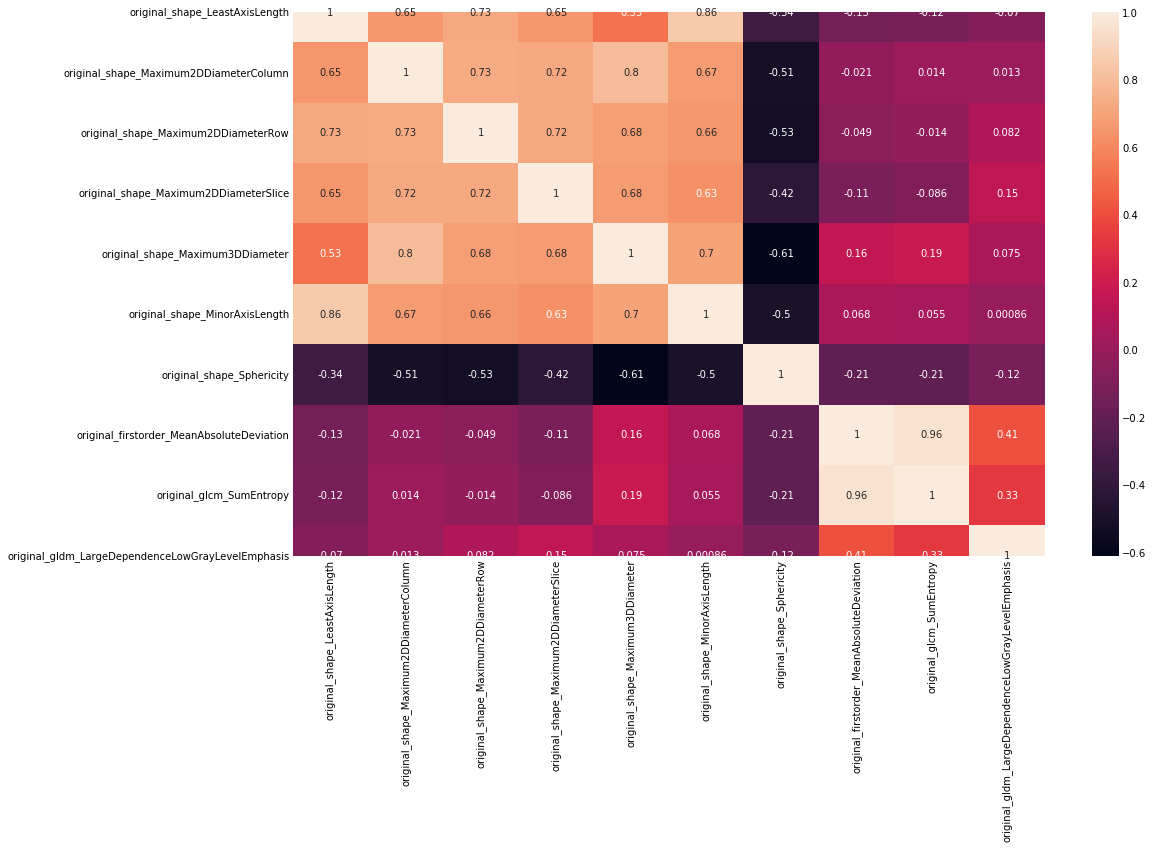

In [23]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)
plt.show()